# Ensemble Model Training (Improved)

## 1. Imports and Setup

In [5]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold, RandomizedSearchCV,KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from itertools import cycle

# Set plot style
sns.set_style('whitegrid')

In [9]:
import warnings
warnings.filterwarnings('ignore')

## 2. Load Preprocessed Data

In [6]:
# Load raw training data
df_train = pd.read_csv('../../data/raw/dataset.csv')

# --- Feature Engineering ---
# Identify symptom columns (assuming they are named like 'Symptom_1', 'Symptom_2', etc.)
symptom_cols = [col for col in df_train.columns if 'Symptom_' in col]

# Drop the 'Unnamed: 133' column if it exists
if 'Unnamed: 133' in df_train.columns:
    df_train = df_train.drop('Unnamed: 133', axis=1)

# Get the target variable first
y = df_train['Disease']

# Create a list to hold all unique symptoms
all_symptoms_list = []
for col in symptom_cols:
    # Clean symptom names (remove leading/trailing spaces) and drop NaNs
    cleaned_symptoms = df_train[col].str.strip().dropna().unique()
    all_symptoms_list.extend(cleaned_symptoms)

# Get unique symptoms
unique_symptoms = sorted(list(set(all_symptoms_list)))
print(f"Found {len(unique_symptoms)} unique symptoms.")

# Create the new feature matrix initialized with zeros
X_processed = pd.DataFrame(0, index=df_train.index, columns=unique_symptoms)

# Populate the matrix: 1 if the symptom is present for the row, 0 otherwise
for index, row in df_train.iterrows():
    present_symptoms = [s.strip() for s in row[symptom_cols].dropna().tolist() if isinstance(s, str) and s.strip()]
    for symptom in present_symptoms:
        if symptom in X_processed.columns:
            X_processed.loc[index, symptom] = 1

# --- Target Encoding ---
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
target_names = le_target.classes_.tolist()
feature_names = X_processed.columns.tolist()  

# --- Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

Found 131 unique symptoms.


In [7]:
print("Data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of classes: {len(target_names)}")


Data loaded successfully.
X_train shape: (3936, 131)
y_train shape: (3936,)
Number of features: 131
Number of classes: 41


## 3. Define Models and Hyperparameter Grids

In [8]:
# Define base models
models = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'), 
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), 
    'lr': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ) #
}

# Define parameter grids for RandomizedSearchCV - Adjusted for Regularization
param_grids = {
    'rf': {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5], 
        'max_features': ['sqrt', 'log2']
    },
    'xgb': {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [5, 7, 10, 12], 
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0], 
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
        'reg_alpha': [0, 0.01, 0.1, 0.5], 
        'reg_lambda': [0.5, 1, 1.5], 
        'gamma': [0, 0.1, 0.2] 
    },
    'lr': {
        'C': [0.01, 0.1, 1, 10], 
        'penalty': ['l1', 'l2']
    },
}

## 4. Hyperparameter Tuning with Randomized Search and Stratified K-Fold

In [10]:
best_models = {}
model_scores = {}
n_iter_search = 20 

# Use Stratified K-Fold for cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n--- Training {name.upper()} ---")
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=n_iter_search,
        cv=cv_strategy,
        scoring='f1_weighted', 
        n_jobs=-1, 
        verbose=1,
        random_state=42
    )
    
    try:
        random_search.fit(X_train, y_train)
        best_models[name] = random_search.best_estimator_
        
        # Evaluate on the test set
        y_pred = best_models[name].predict(X_test)
        score = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        model_scores[name] = score
        
        print(f"\n{name.upper()} Best Parameters:", random_search.best_params_)
        print(f"\n{name.upper()} Test Set Performance (Weighted Avg F1): {score['weighted avg']['f1-score']:.4f}")
        print(f"\n{name.upper()} Full Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))
        
    except Exception as e:
        print(f"An error occurred during training/evaluation for {name}: {e}")

print("\n--- Hyperparameter Tuning Complete ---")


--- Training RF ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

RF Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}

RF Test Set Performance (Weighted Avg F1): 1.0000

RF Full Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00  

## 5. Ensemble Voting Classifier

In [ ]:
if len(best_models) == len(models): # Ensure all models trained successfully
    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in best_models.items()],
        voting='soft',
        n_jobs=-1
    )

    try:
        print("\n--- Training Voting Classifier ---")
        voting_clf.fit(X_train, y_train)
        
        # Evaluate the ensemble model
        y_pred_voting = voting_clf.predict(X_test)
        voting_score_report = classification_report(y_test, y_pred_voting, target_names=target_names, output_dict=True)
        model_scores['voting_clf'] = voting_score_report
        
        print("\nVoting Classifier Test Set Performance (Weighted Avg F1):", f"{voting_score_report['weighted avg']['f1-score']:.4f}")
        print("\nVoting Classifier Full Classification Report:\n", classification_report(y_test, y_pred_voting, target_names=target_names))
        
    except Exception as e:
        print(f"An error occurred during Voting Classifier training/evaluation: {e}")
        voting_clf = None # Ensure voting_clf is None if it failed
else:
    print("\nSkipping Voting Classifier as not all base models were trained successfully.")
    voting_clf = None


--- Training Voting Classifier ---

Voting Classifier Test Set Performance (Weighted Avg F1): 1.0000

Voting Classifier Full Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis

## 6. Learning Curve Analysis


--- Generating Learning Curve ---


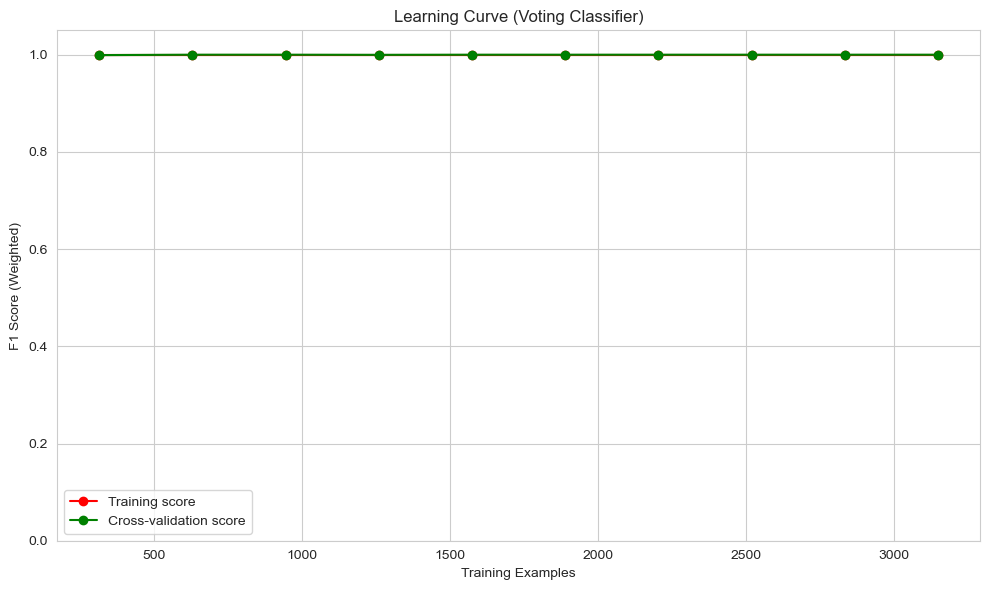

In [12]:
# Plot learning curve for the ensemble model to check for overfitting/underfitting
if voting_clf is not None:
    print("\n--- Generating Learning Curve ---")
    try:
        train_sizes_abs, train_scores, valid_scores = learning_curve(
            voting_clf,
            X_train, 
            y_train,
            train_sizes=np.linspace(0.1, 1.0, 10), 
            cv=cv_strategy, # Use the same stratified K-Fold
            scoring='f1_weighted',
            n_jobs=-1
        )
        
        # Compute mean and standard deviation
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes_abs, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes_abs, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.title("Learning Curve (Voting Classifier)")
        plt.xlabel("Training Examples")
        plt.ylabel("F1 Score (Weighted)")
        plt.legend(loc="best")
        plt.grid(True)
        plt.ylim(0.0, 1.05) # Set y-axis limits for better comparison
        plt.tight_layout()
        plt.savefig('../../reports/figures/learning_curve_ensemble_improved.png')
        plt.show()
        
    except Exception as e:
        print(f"Could not generate learning curve: {e}")
else:
    print("\nSkipping Learning Curve generation as Voting Classifier is not available.")

## 7. Advanced Analysis Functions

In [15]:
# Function to plot ROC curves for multi-class classification
def plot_roc_curves(models_dict, X, y, target_names, filename='../../reports/figures/roc_curves_improved.png'):
    n_classes = len(target_names)
    y_bin = label_binarize(y, classes=range(n_classes))
    
    plt.figure(figsize=(12, 10))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy'])
    lw = 2

    all_fpr = {}
    all_tpr = {}
    all_roc_auc = {}

    for name, model in models_dict.items():
        try:
            y_score = model.predict_proba(X)
            
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            
            all_fpr[name] = fpr["micro"]
            all_tpr[name] = tpr["micro"]
            all_roc_auc[name] = roc_auc["micro"]
            
        except Exception as e:
            print(f"Could not compute ROC for {name}: {e}")
            continue

    # Plot all micro-average ROC curves
    for (name, fpr), tpr, roc_auc, color in zip(all_fpr.items(), all_tpr.values(), all_roc_auc.values(), colors):
         plt.plot(fpr, tpr, color=color, lw=lw,
                 label=f'{name} (micro-avg AUC = {roc_auc:0.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average ROC Curves for Trained Models')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Function to analyze symptom-disease relationships (calculates mean symptom presence per disease)
def analyze_disease_symptom_relationships(X, y, feature_names, target_names):
    # Ensure y is integer-coded if it's not already
    # This assumes y corresponds to indices of target_names
    unique_labels = np.unique(y)
    if not all(isinstance(label, (int, np.integer)) for label in unique_labels):
        # Attempt to map if target_names aligns with unique string labels
        try:
            label_map = {name: i for i, name in enumerate(target_names)}
            y_mapped = np.array([label_map[label] for label in y])
            print("Mapped string labels in y to integers.")
        except Exception as e:
             print(f"Could not map y labels to integers: {e}. Ensure y contains integer labels corresponding to target_names indices.")
             return None
    else:
        y_mapped = y # Assume y is already integer coded correctly
        
    relationships = pd.DataFrame(index=feature_names, columns=target_names)
    for disease_idx, disease in enumerate(target_names):
        # Find rows corresponding to the current disease index
        disease_mask = (y_mapped == disease_idx)
        if np.sum(disease_mask) > 0:
            disease_cases = X[disease_mask]
            # Calculate mean for each symptom (feature) for this disease
            symptom_frequencies = np.mean(disease_cases, axis=0)
            relationships[disease] = symptom_frequencies
        else:
            print(f"Warning: No samples found for disease index {disease_idx} ({disease}). Skipping.")
            relationships[disease] = np.nan # Fill with NaN if no samples
            
    return relationships

## 8. Execute Advanced Analysis


--- Generating ROC Curves ---


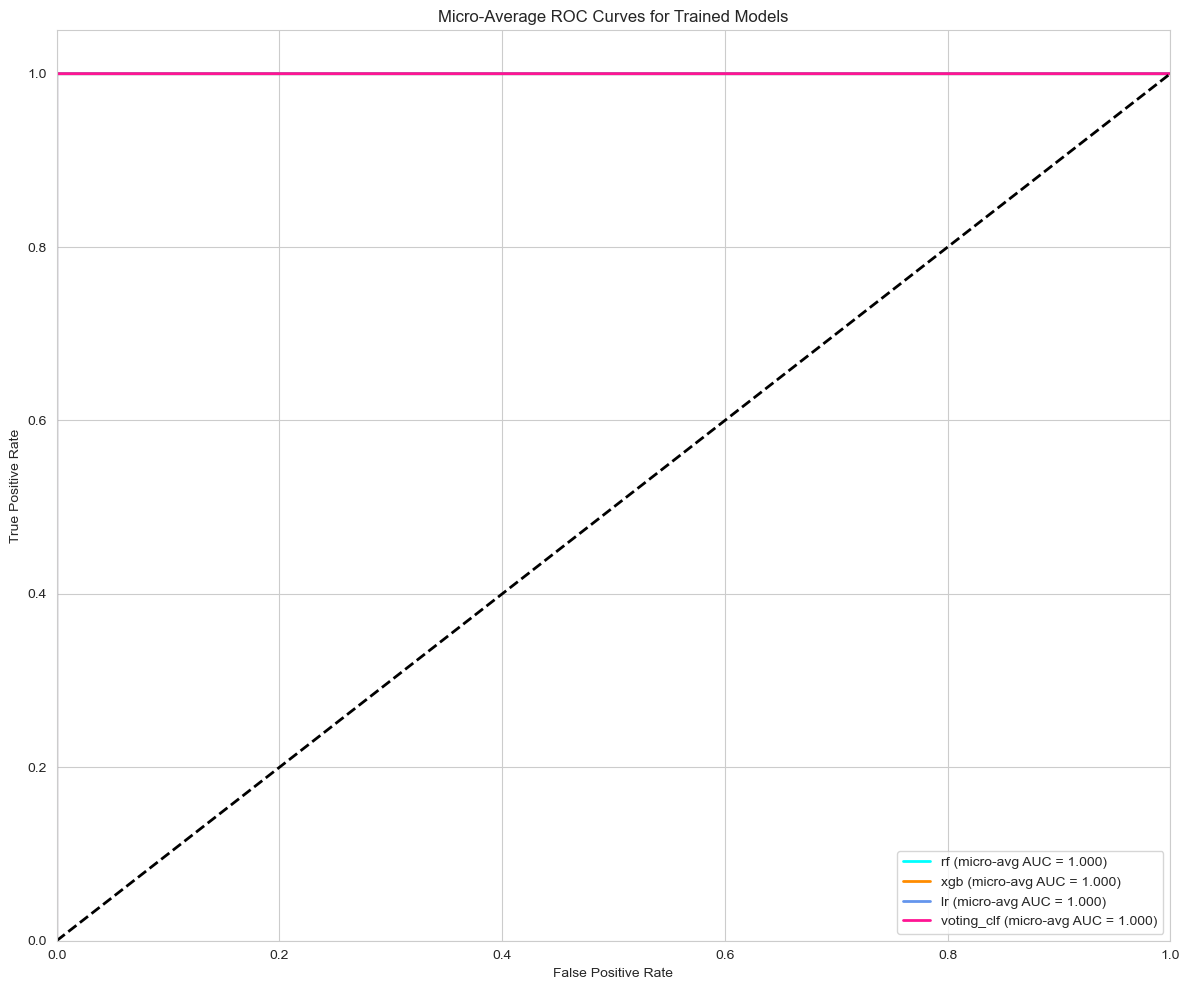


--- Analyzing Symptom-Disease Relationships ---
Symptom-disease relationships saved to '../../data/processed/symptom_disease_relationships_improved.csv'


In [16]:
# Plot ROC curves for all trained models including the ensemble
models_to_plot = best_models.copy()
if voting_clf is not None:
    models_to_plot['voting_clf'] = voting_clf

if models_to_plot:
    print("\n--- Generating ROC Curves ---")
    plot_roc_curves(models_to_plot, X_test, y_test, target_names)
else:
    print("\nSkipping ROC curve generation as no models are available.")

# Analyze and save symptom-disease relationships using training data
print("\n--- Analyzing Symptom-Disease Relationships ---")
relationships = analyze_disease_symptom_relationships(X_train, y_train, feature_names, target_names)
if relationships is not None:
    try:
        relationships.to_csv('../../data/processed/symptom_disease_relationships_improved.csv')
        print("Symptom-disease relationships saved to '../../data/processed/symptom_disease_relationships_improved.csv'")
    except Exception as e:
        print(f"Could not save symptom-disease relationships: {e}")
else:
    print("Symptom-disease relationship analysis failed.")

## 9. Visualizations (Feature Importance & Confusion Matrices)


--- Generating Visualizations ---


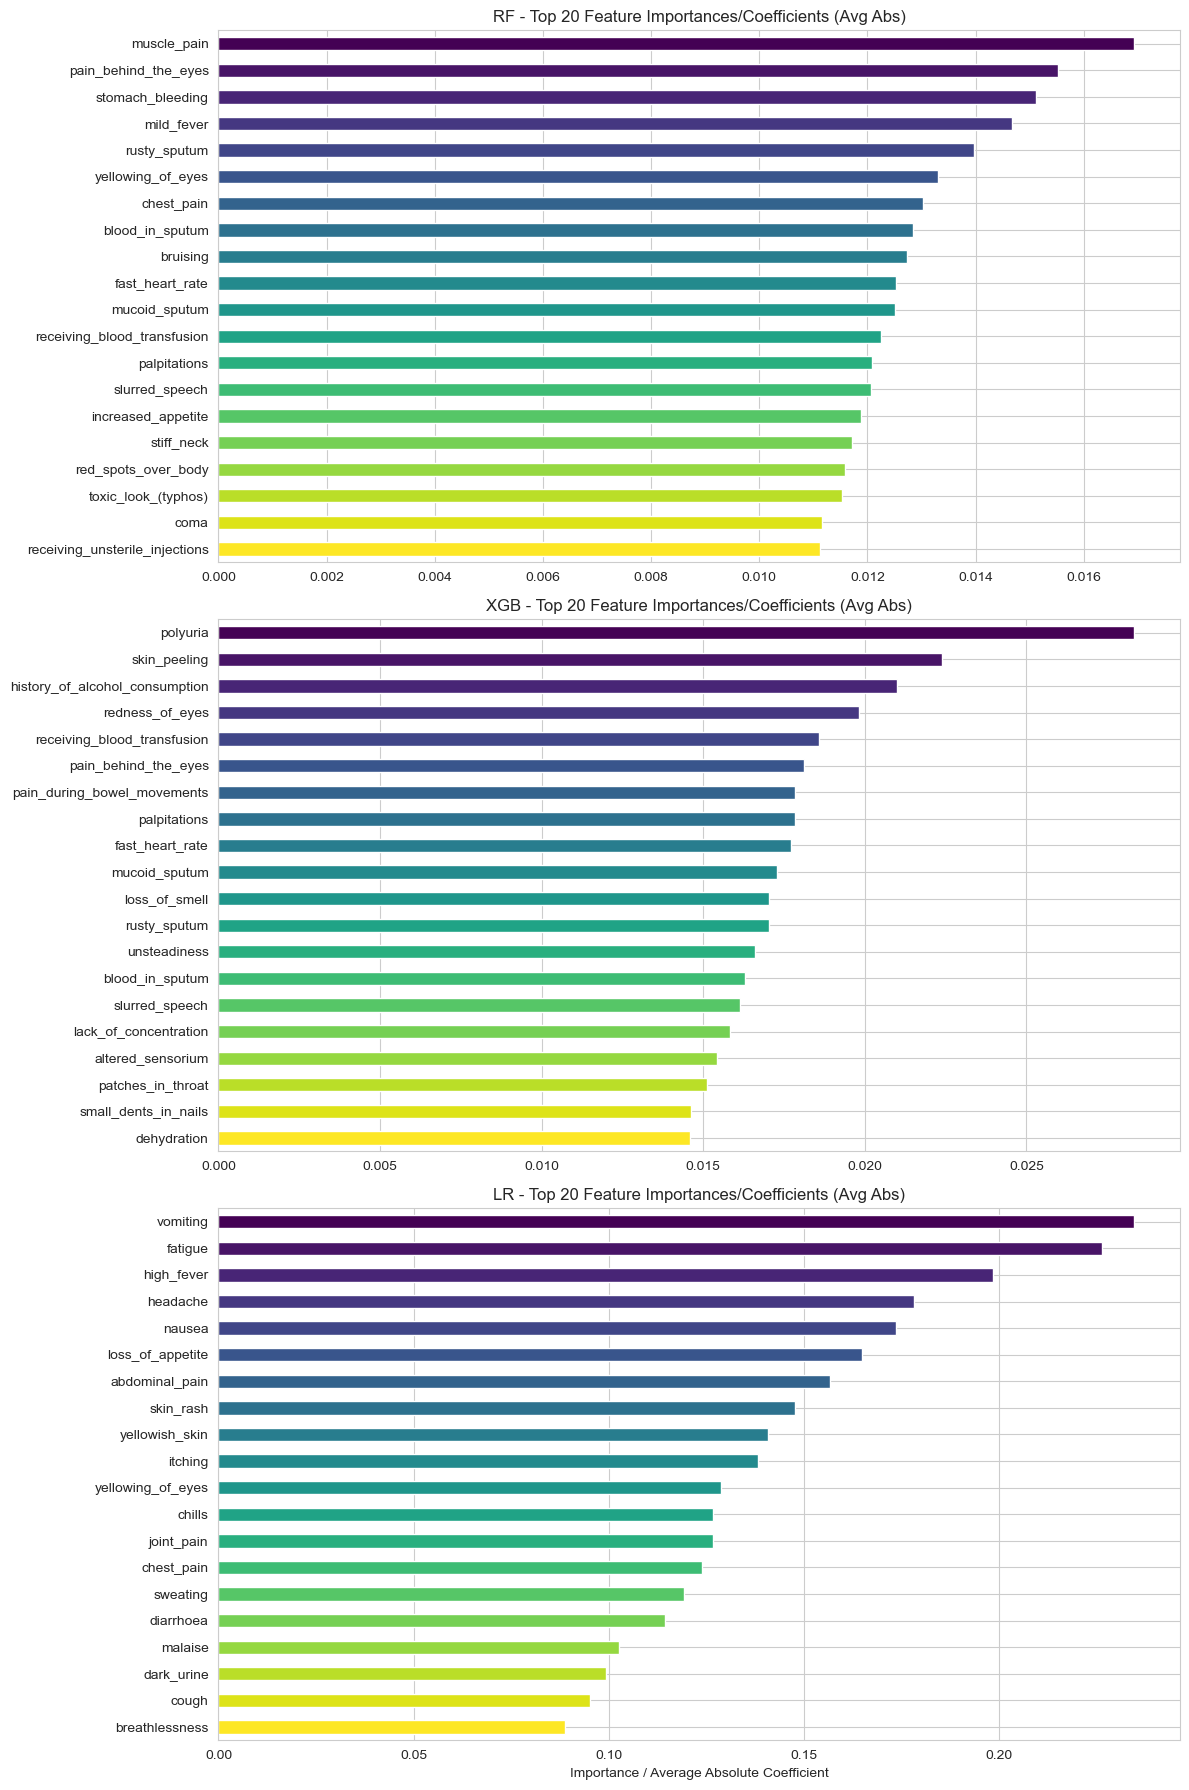

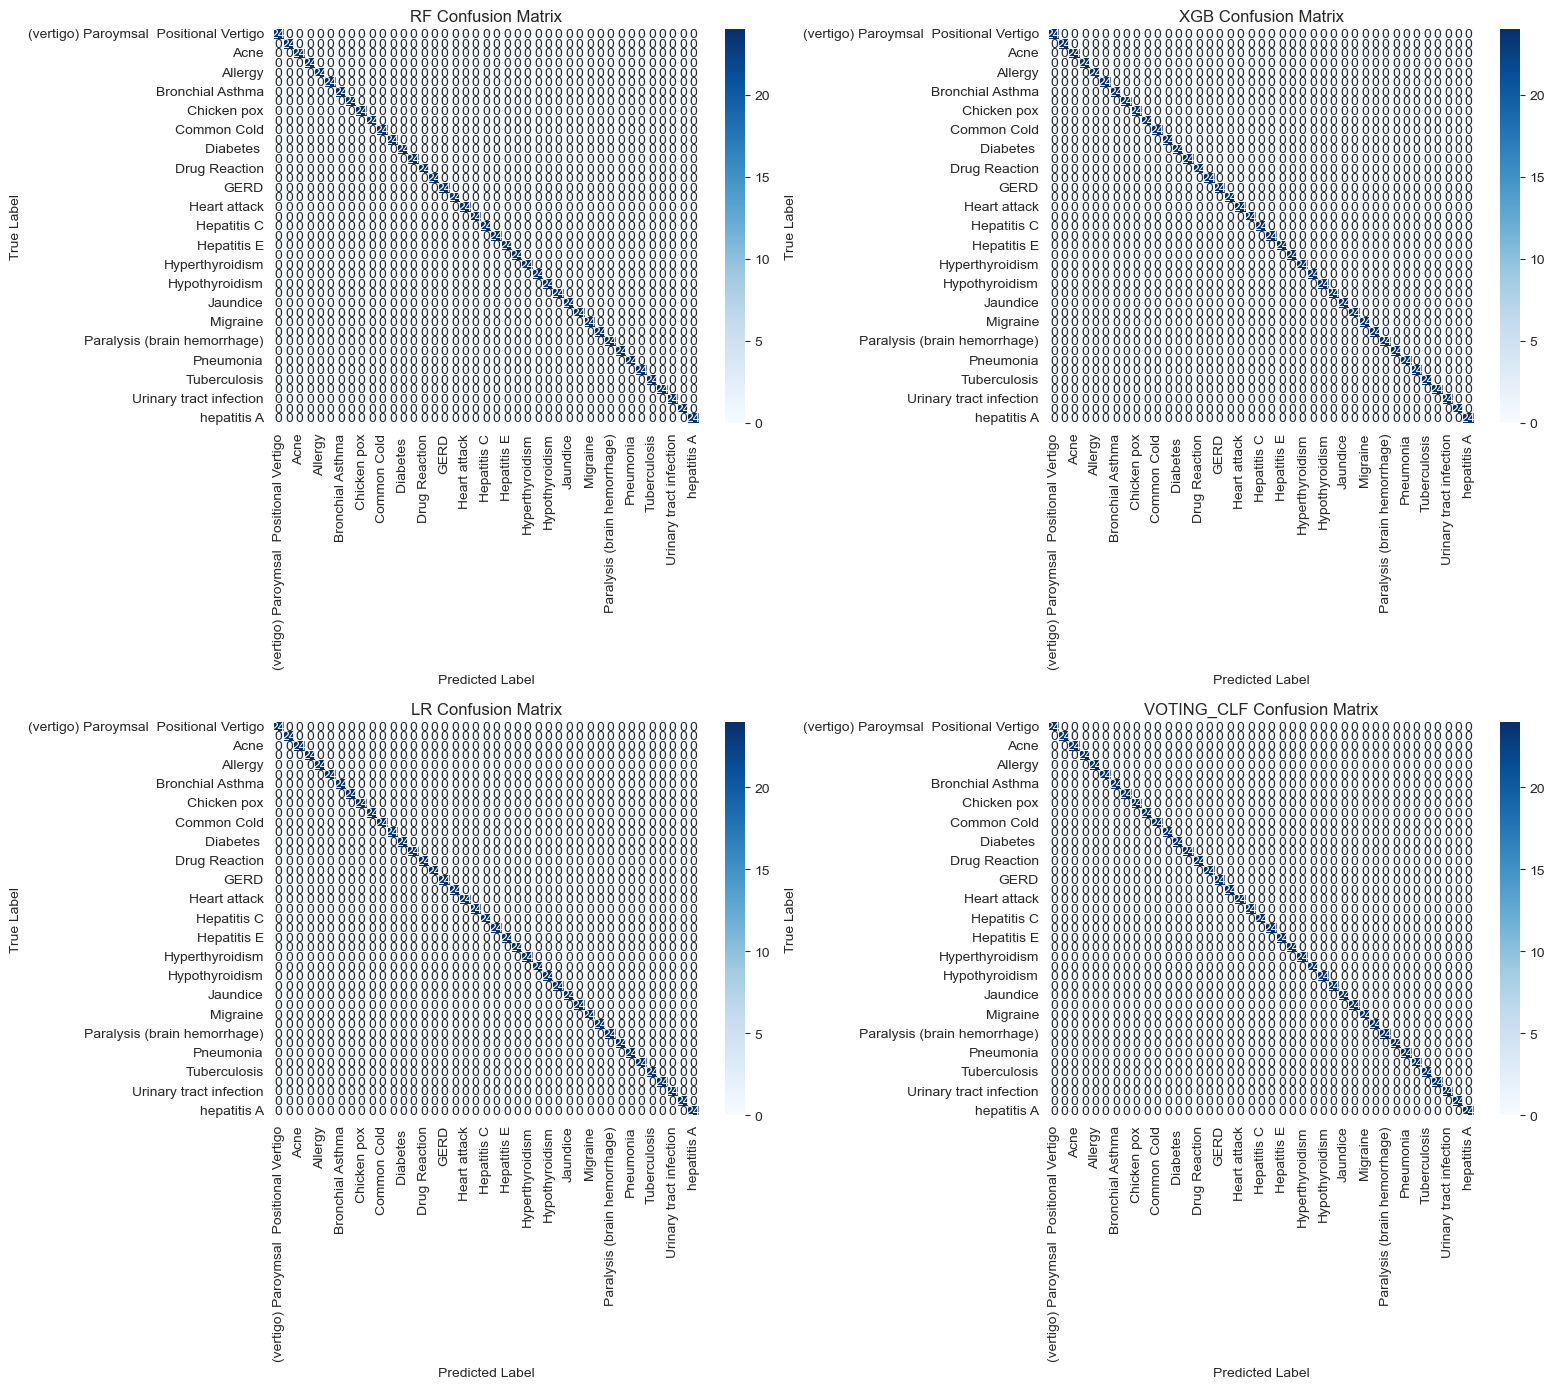

In [17]:
# Function to create and save visualizations
def create_visualizations(models_dict, X_test_data, y_test_data, feature_names_list, target_names_list):
    print("\n--- Generating Visualizations ---")
    
    # --- Feature Importance/Coefficients --- 
    num_features_to_show = 20 # Show top N features
    feature_importances = {}

    for name, model in models_dict.items():
        if hasattr(model, 'feature_importances_'): # For RF, XGB
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_importances[name] = pd.Series(importances[indices][:num_features_to_show], index=[feature_names_list[i] for i in indices[:num_features_to_show]])
        elif hasattr(model, 'coef_'): # For Logistic Regression
            # For multi-class LR, coef_ is (n_classes, n_features). We average absolute coefficients across classes.
            if model.coef_.shape[0] > 1:
                avg_abs_coef = np.mean(np.abs(model.coef_), axis=0)
            else:
                avg_abs_coef = np.abs(model.coef_.ravel())
            indices = np.argsort(avg_abs_coef)[::-1]
            feature_importances[name] = pd.Series(avg_abs_coef[indices][:num_features_to_show], index=[feature_names_list[i] for i in indices[:num_features_to_show]])
        # VotingClassifier doesn't have direct feature importance

    # Plotting feature importances
    if feature_importances:
        num_plots = len(feature_importances)
        fig, axes = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots), sharex=False)
        if num_plots == 1:
            axes = [axes] # Make it iterable
            
        for ax, (name, importance_series) in zip(axes, feature_importances.items()):
            importance_series.plot(kind='barh', ax=ax, color=plt.cm.viridis(np.linspace(0, 1, len(importance_series))))
            ax.set_title(f'{name.upper()} - Top {num_features_to_show} Feature Importances/Coefficients (Avg Abs)')
            ax.invert_yaxis() # Highest importance at the top
        
        plt.xlabel('Importance / Average Absolute Coefficient')
        plt.tight_layout()
        plt.savefig('../../reports/figures/feature_importance_comparison_improved.png')
        plt.show()
    else:
        print("No feature importance information available to plot.")

    # --- Confusion Matrices --- 
    num_models_cm = len(models_dict)
    if num_models_cm > 0:
        ncols = 2
        nrows = (num_models_cm + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 7 * nrows))
        axes = axes.flatten() # Flatten to easily iterate

        for i, (name, model) in enumerate(models_dict.items()):
            try:
                y_pred_cm = model.predict(X_test_data)
                cm = confusion_matrix(y_test_data, y_pred_cm)
                cm_df = pd.DataFrame(cm, index=target_names_list, columns=target_names_list)
                
                sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[i])
                axes[i].set_title(f'{name.upper()} Confusion Matrix')
                axes[i].set_ylabel('True Label')
                axes[i].set_xlabel('Predicted Label')
            except Exception as e:
                print(f"Could not generate confusion matrix for {name}: {e}")
                axes[i].set_title(f'{name.upper()} - Error')
                axes[i].text(0.5, 0.5, 'Error generating matrix', ha='center', va='center')
        
        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.savefig('../../reports/figures/confusion_matrices_improved.png')
        plt.show()
    else:
        print("No models available to generate confusion matrices.")

# Call the visualization function with all models
create_visualizations(models_to_plot, X_test, y_test, feature_names, target_names)

## 10. Save Results

In [18]:
# Save the best models, the voting classifier, feature/target names, and scores
if voting_clf is not None and best_models:
    results = {
        'best_individual_models': best_models,
        'voting_classifier': voting_clf,
        'feature_names': feature_names,
        'target_names': target_names,
        'model_scores': model_scores
    }

    try:
        save_path = '../../models/ensemble_models_improved.joblib'
        joblib.dump(results, save_path)
        print(f"\nResults (models, names, scores) saved successfully to {save_path}")
    except Exception as e:
        print(f"\nError saving results: {e}")
else:
    print("\nSkipping saving results as not all components are available.")


Results (models, names, scores) saved successfully to ../../models/ensemble_models_improved.joblib


## 11. Next Steps

The improved ensemble model (`voting_classifier`) and associated data are saved in `models/ensemble_models_improved.joblib`.

This file can now be loaded in a separate script (e.g., for the Gradio interface) to make predictions.

Key improvements made:
- Used `StratifiedKFold` for more robust cross-validation.
- Employed `RandomizedSearchCV` for efficient hyperparameter tuning.
- Included regularization parameters in tuning grids to combat overfitting.
- Used uniform weights for the `VotingClassifier`.
- Generated a learning curve to assess model bias/variance.
- Implemented ROC curve plotting for multi-class evaluation.
- Improved feature importance visualization.
- Added analysis of symptom-disease relationships.
- Structured the notebook with clear sections and comments.